In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display

%matplotlib inline

<strong>Ще разгледаме dataset с данни за служители, и ще се опитаме да разберем, какво ги кара да напуснат работа</strong><br>
<strong>Данните са взети от dataset в kaggle - Human Resources Analytics</strong>

In [2]:
pd.options.display.max_rows = 11

pd.read_csv('data/hr/HR_comma_sep.csv')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


На пръв поглед данните изглеждат добре

In [3]:
data = pd.read_csv('data/hr/HR_comma_sep.csv')
original = data.copy()
data.isnull().sum().sort_values()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

Данните са супер чисти и нямаме null стойности, има 2 колони, които сигурно ще one-hot-encode-нем в последствие (sales, salary)

Да пробваме с това колко са натоварени хората, т.е проектите и колко работят на месец

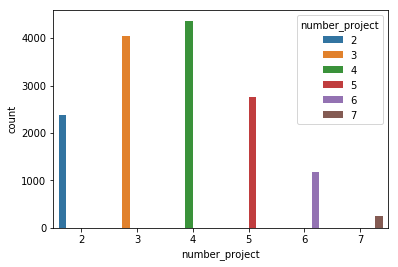

In [4]:
sns.countplot('number_project', hue='number_project', data=data);


In [5]:
temp = data.copy()
temp['workingHours']=pd.qcut(temp['average_montly_hours'],4)
temp.groupby(['workingHours'])['left'].mean().to_frame()

,left
workingHours,
"(95.999, 156.0]",0.362118
"(156.0, 200.0]",0.072609
"(200.0, 245.0]",0.142178
"(245.0, 310.0]",0.373070


Данните за работни часове на месец малко ме бъркат, да пробваме със стандартното 40 работни часа на седмица

In [6]:
temp['weeklyHours']=pd.qcut(temp['average_montly_hours']/4,4)
temp.groupby(['weeklyHours'])['left'].mean().to_frame()

,left
weeklyHours,
"(23.999, 39.0]",0.362118
"(39.0, 50.0]",0.072609
"(50.0, 61.25]",0.142178
"(61.25, 77.5]",0.373070


Така е по-добре<br><br>
Хората, който работят под средната работна седмица и тези с над 60 часа изглежда, че имат доста по-голям шанс за напускане от останалите><br>
Претоварването и другата крайност(липсата на работа) може би водят хората до напускане на своята работа

Да проверим, дали има връзка между проектите и напусналите

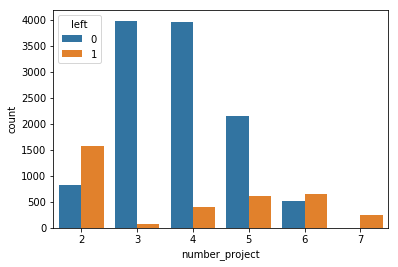

In [7]:
sns.countplot('number_project', hue='left', data=data);


Виждаме, че при хората, които работят по много проекти (6,7) напусналите са голям процент, при 7 са си направо 100% :D <br>
При 2 проекта имаме стойности почти 1:2 , да видим

In [8]:
two_projects = temp[temp.number_project == 2]['left']

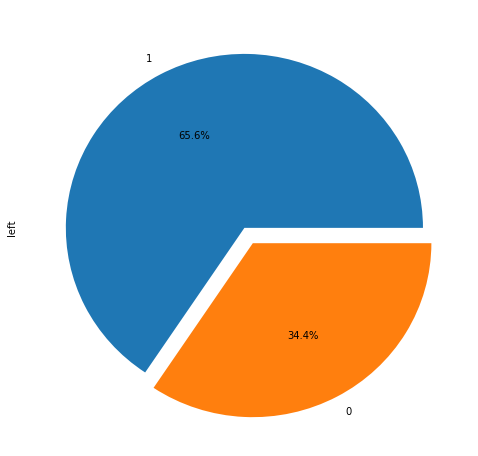

In [9]:
two_projects.value_counts().plot.pie(explode=[0, 0.1], figsize=(8, 8), autopct='%1.1f%%');


Много работа, малко работа ....   да проверим как е при отделите

In [10]:
data['sales'].value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: sales, dtype: int64

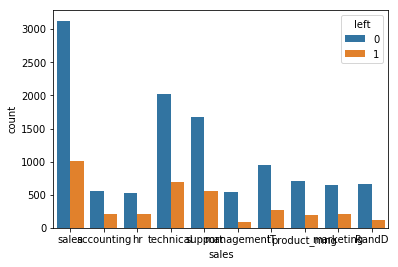

In [11]:
sns.countplot('sales', hue='left', data=data);


Отделът, в който работи служителят, няма огромно значение на пръв поглед

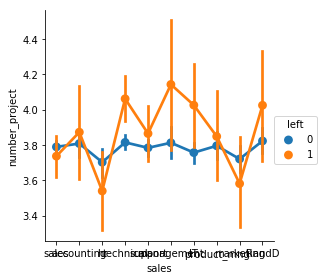

In [12]:
sns.factorplot(x='sales',y='number_project',hue='left', data=data);


Много гъч <br>

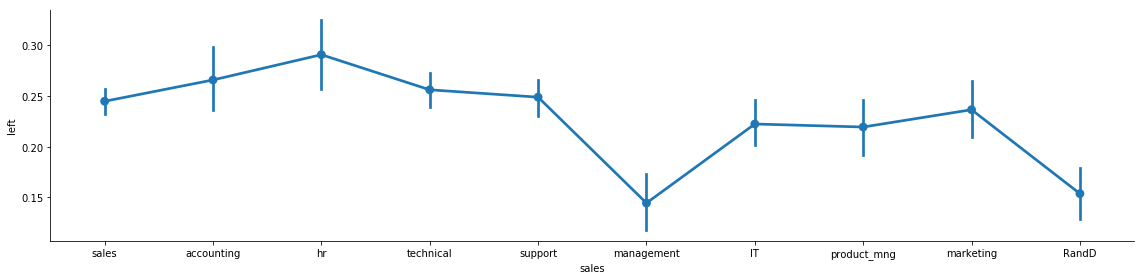

In [13]:
sns.factorplot(x='sales',y='left',data=data,size=4, aspect=4);

Да пробваме да добавим и заплатите

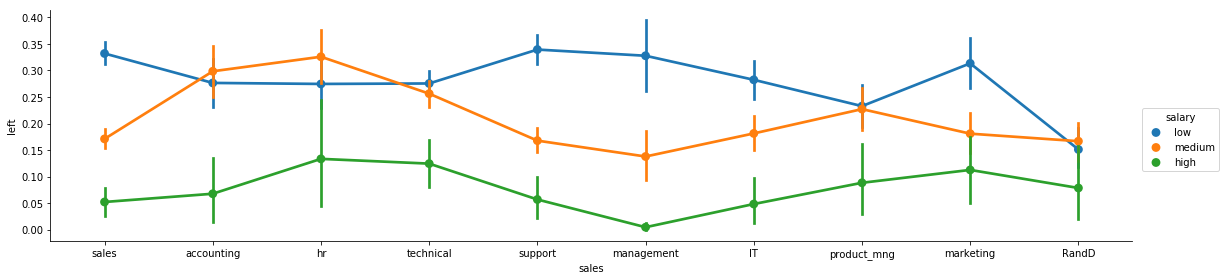

In [14]:
sns.factorplot(x='sales', y='left', hue='salary', data=data,size=4, aspect=4);

Заплащането е добре разпределено, но е странно, че при някой заплащането между low и medium не е фактор

<strong>Да си one-hot-нем отделите</strong>

In [15]:
def one_hot_sales(data):
    for dep in data['sales'].value_counts().keys():
        data['Is'+dep] = (data['sales'].astype(str)==dep).astype(float) 
   

In [16]:
one_hot_sales(data)

А сега и заплатите

In [17]:
#deps_with_no_salary_factor = ['accounting','hr','technical','product_mng','RandD']
def one_hot_salary(data):
    for salary in data['salary'].value_counts().keys():
        data['Is'+salary] = (data['salary'].astype(str)==salary).astype(float)

In [18]:
one_hot_salary(data)
data

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,...,IsIT,Isproduct_mng,Ismarketing,IsRandD,Isaccounting,Ishr,Ismanagement,Islow,Ismedium,Ishigh
0,0.38,0.53,2,157,3,0,1,0,sales,low,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.11,0.88,7,272,4,0,1,0,sales,medium,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.72,0.87,5,223,5,0,1,0,sales,low,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.37,0.52,2,159,3,0,1,0,sales,low,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14995,0.37,0.48,2,160,3,0,1,0,support,low,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14996,0.37,0.53,2,143,3,0,1,0,support,low,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14997,0.11,0.96,6,280,4,0,1,0,support,low,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Да си направим колона със средна работна седмица и още 1 с коефициент  работна <strong>седмица / реална средна работна седмица</strong>(40)

In [19]:
def create_weekly_hours(data):
    data['average_weekly_hours'] =data['average_montly_hours'].mean()/4
    
def create_week_coef(data):
    data['weekly_coef'] = data['average_weekly_hours']/40
    
create_weekly_hours(data)
create_week_coef(data)


Да тренираме модел и да видим какво ще излезе

In [20]:
data = data.drop(['sales','salary'],1)
X = data.drop('left', axis=1)
y = data['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

<strong>Логистична регресия</strong>

In [21]:
model = LogisticRegression()
model.fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.798559871989
test score:  0.794133333333


In [22]:
for c in [0.001, 0.003, 0.006, 0.1, 0.3, 0.6, 1.0, 3.0, 6.0,7.0]:
    model = LogisticRegression(C=c)
    model.fit(X_train, y_train)
    
    print("C={:f} train: {:f} test: {:f}".format(c, model.score(X_train, y_train), model.score(X_test, y_test)))

C=0.001000 train: 0.759267 test: 0.759200
C=0.003000 train: 0.754023 test: 0.753867
C=0.006000 train: 0.757845 test: 0.752267
C=0.100000 train: 0.791270 test: 0.788533
C=0.300000 train: 0.797138 test: 0.793067
C=0.600000 train: 0.798204 test: 0.793600
C=1.000000 train: 0.798560 test: 0.794133
C=3.000000 train: 0.799538 test: 0.793867
C=6.000000 train: 0.799804 test: 0.794133
C=7.000000 train: 0.799804 test: 0.794133


Няма голяма разлика, C=1 e OK, C=6 e малко по-добро

In [23]:
def logistic_regression_features(X, model):
    plt.figure(figsize=(12,8))
    barplot = sns.barplot(x=X.columns, y=model.coef_[0], orient='vertical')
    plt.setp(barplot.get_xticklabels(), rotation=90)
    plt.grid(True)

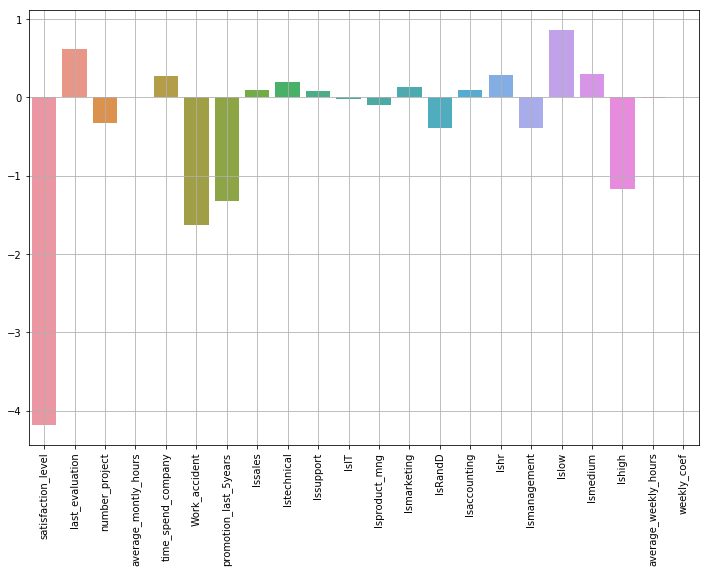

In [24]:
logistic_regression_features(X, model)


last_evaluation има голямо значение

,left
Eval,
"(0.359, 0.56]",0.374396
"(0.56, 0.72]",0.057143
"(0.72, 0.87]",0.203302
"(0.87, 1.0]",0.313157


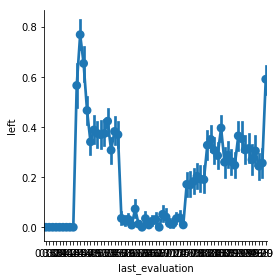

In [25]:
sns.factorplot(x='last_evaluation',y='left', data=data);
temp['Eval']=pd.qcut(temp['last_evaluation'],4)
temp.groupby(['Eval'])['left'].mean().to_frame()

<strong>Да разцепим evaluation</strong>

In [27]:
def one_hot_eval(data):
    data['Eval1'] = ((data.last_evaluation> 0.359) & (data.last_evaluation <= 0.56)).astype(float)
    data['Eval2'] = ((data.last_evaluation > 0.56) & (data.last_evaluation <=  0.72)).astype(float)
    data['Eval3'] = ((data.last_evaluation > 0.72) & (data.last_evaluation <= 0.87)).astype(float)
    data['Eval4'] = ((data.last_evaluation > 0.87) & (data.last_evaluation <= 1)).astype(float)

train score: 0.827540225798
test score:  0.820533333333


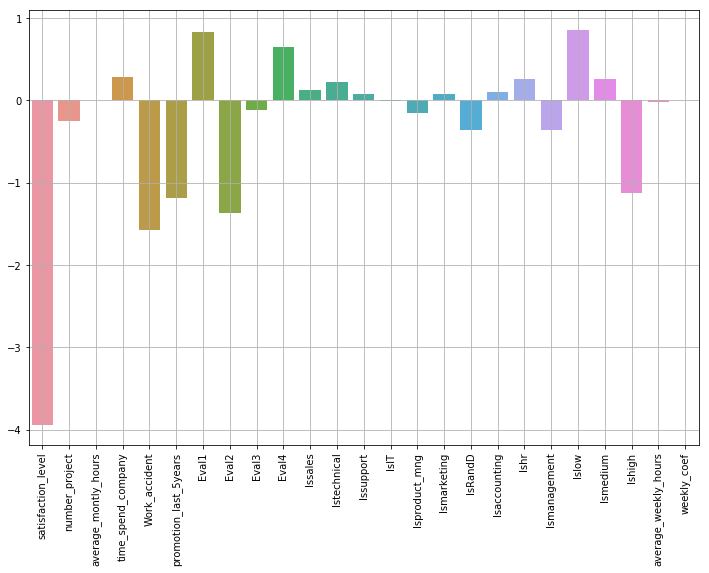

In [28]:
one_hot_eval(original)
one_hot_sales(original)
one_hot_salary(original)
create_weekly_hours(original)
create_week_coef(original)

original = original.drop(['sales','salary','last_evaluation'],1)
X = original.drop('left', axis=1)
y = original['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

model = LogisticRegression()
model.fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

logistic_regression_features(X, model)


Вдигнахме резултата с 3%

Може би резултата за регресия ще се вдигне с някой процент, ако погледнем isLow и Eval1,Eval4, но да пробваме друг подход

<strong>А сега с гора</strong>

In [29]:
model = RandomForestClassifier(random_state=0).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.997777580229
test score:  0.986933333333


<strong>Цепи мрака</strong>

In [31]:
def random_forest_features(model, X):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 10))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns, rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.show()

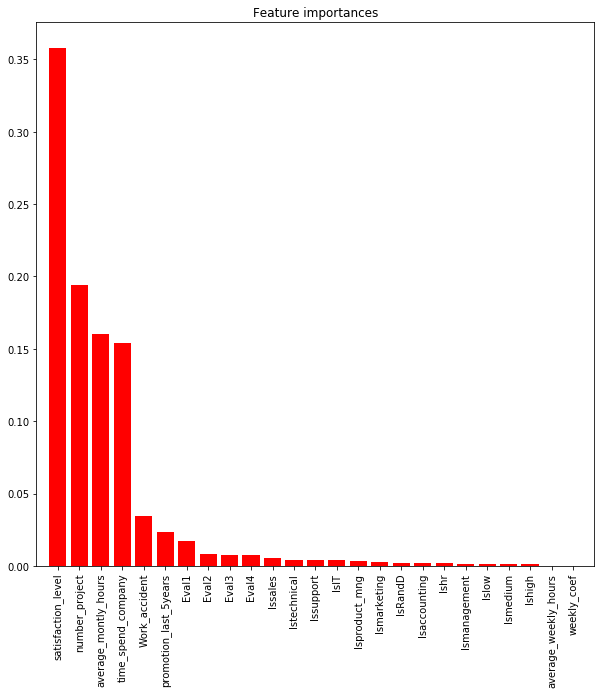

In [32]:
random_forest_features(model, X)
